In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load your dataset
df = pd.read_csv("../2. JSON to CSV/AQI_data_cleaned_INT.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# List of pollutants
pollutants = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'OZONE']

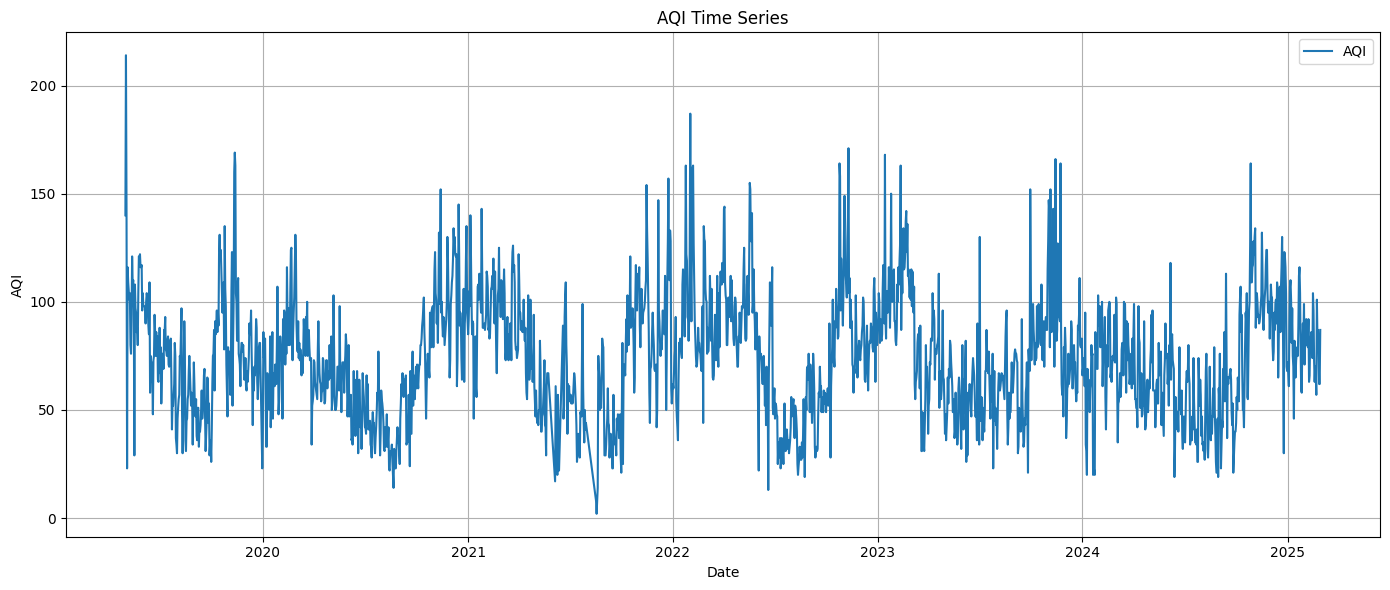

In [3]:
# Plot AQI over time
plt.figure(figsize=(14, 6))
plt.plot(df['AQI'], label='AQI')
plt.title('AQI Time Series')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

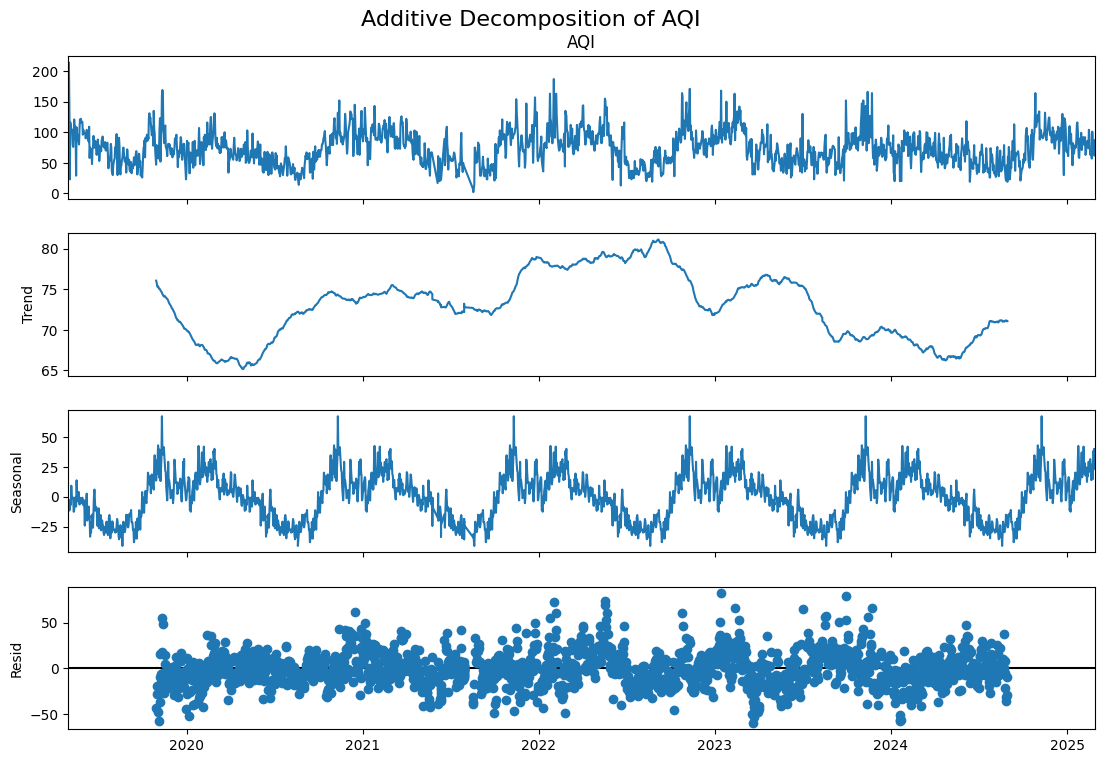

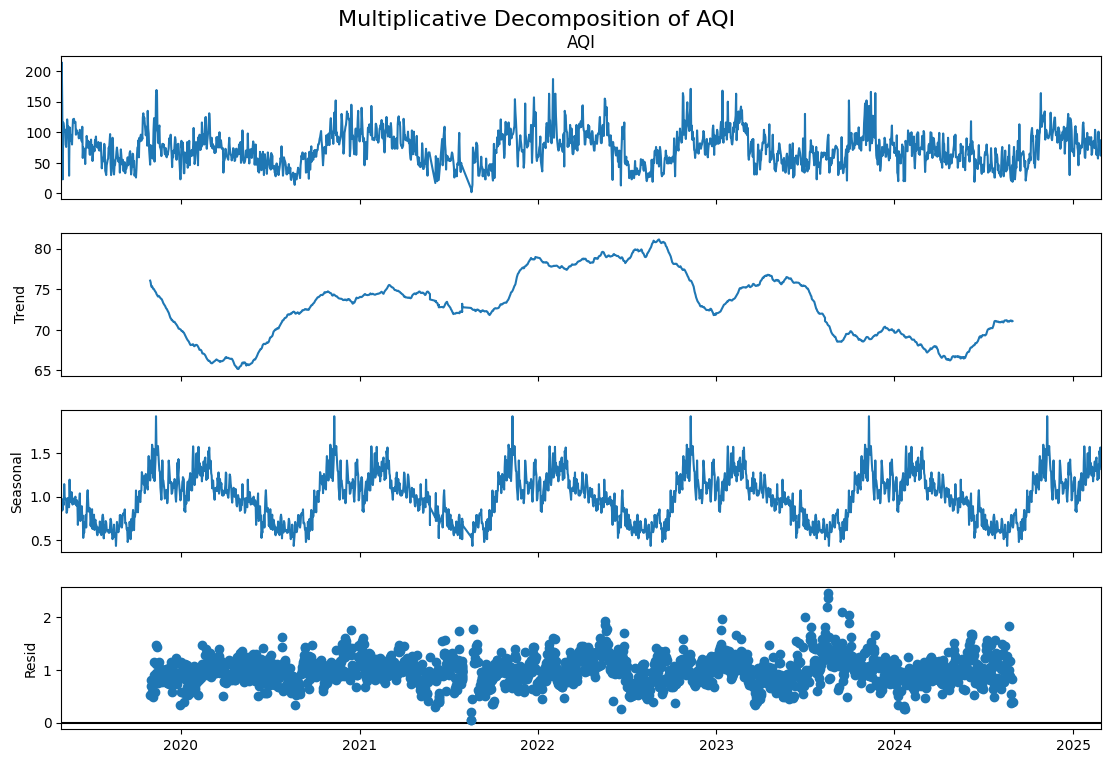

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming your AQI time series is in a DataFrame like this:
# df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)
# df['AQI'] = your AQI values

# --- ADDITIVE DECOMPOSITION ---
result_add = seasonal_decompose(df['AQI'], model='additive', period=365)
fig = result_add.plot()
fig.set_size_inches(12, 8)
fig.suptitle('Additive Decomposition of AQI', fontsize=16)
plt.show()

# --- MULTIPLICATIVE DECOMPOSITION ---
result_mult = seasonal_decompose(df['AQI'], model='multiplicative', period=365)
fig = result_mult.plot()
fig.set_size_inches(12, 8)
fig.suptitle('Multiplicative Decomposition of AQI', fontsize=16)
plt.show()

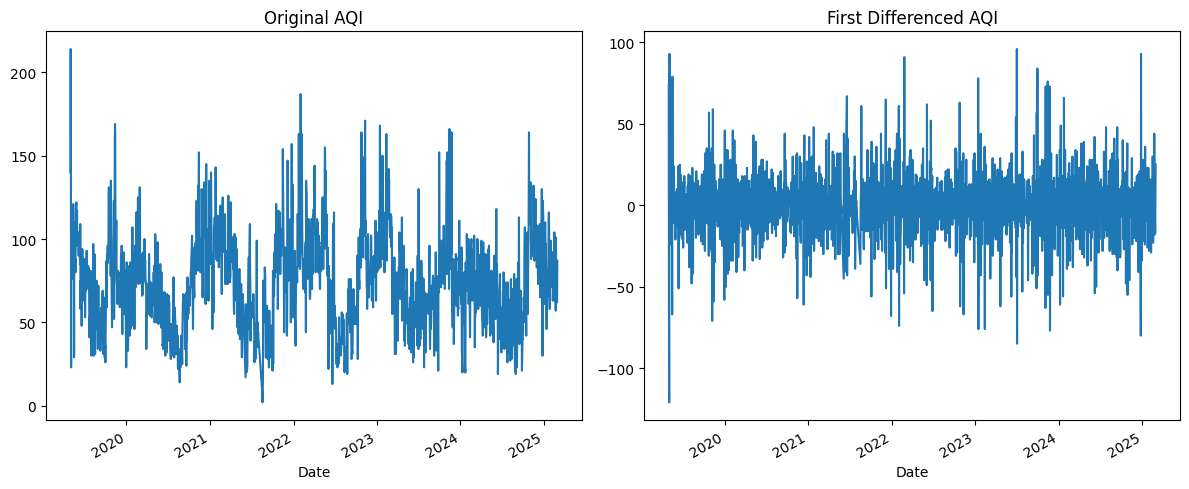

Augmented Dickey-Fuller Test: Original AQI
ADF Statistic : -5.669463553837838
p-value : 8.991731443350688e-07
# Lags Used : 11
# Observations : 2119
Critical Value (1%) : -3.4334397778912775
Critical Value (5%) : -2.8629049396081134
Critical Value (10%) : -2.5674966284215643
=> The series is stationary ✅


Augmented Dickey-Fuller Test: First Differenced AQI
ADF Statistic : -14.727555598868353
p-value : 2.6912238067696126e-27
# Lags Used : 19
# Observations : 2110
Critical Value (1%) : -3.433452973124137
Critical Value (5%) : -2.862910765700749
Critical Value (10%) : -2.5674997304642755
=> The series is stationary ✅


In [16]:
from statsmodels.tsa.stattools import adfuller

# Load your data (replace with your file if needed)
# df = pd.read_csv('your_file.csv', parse_dates=['Date'], index_col='Date')
# For this example, we assume 'df' already exists and has 'AQI' column with datetime index
ts = df['AQI']

# Define ADF test function
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations']
    for key, val in zip(labels, result[0:4]):
        print(f'{key} : {val}')
    for key, val in result[4].items():
        print(f'Critical Value ({key}) : {val}')
    if result[1] <= 0.05:
        print("=> The series is stationary ✅")
    else:
        print("=> The series is NOT stationary ❌")

# Run ADF test and plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
ts.plot(title='Original AQI')
plt.subplot(1, 2, 2)
ts.diff().plot(title='First Differenced AQI')
plt.tight_layout()
plt.show()

# Perform ADF tests
adf_test(ts, 'Original AQI')
print("\n")
adf_test(ts.diff(), 'First Differenced AQI')


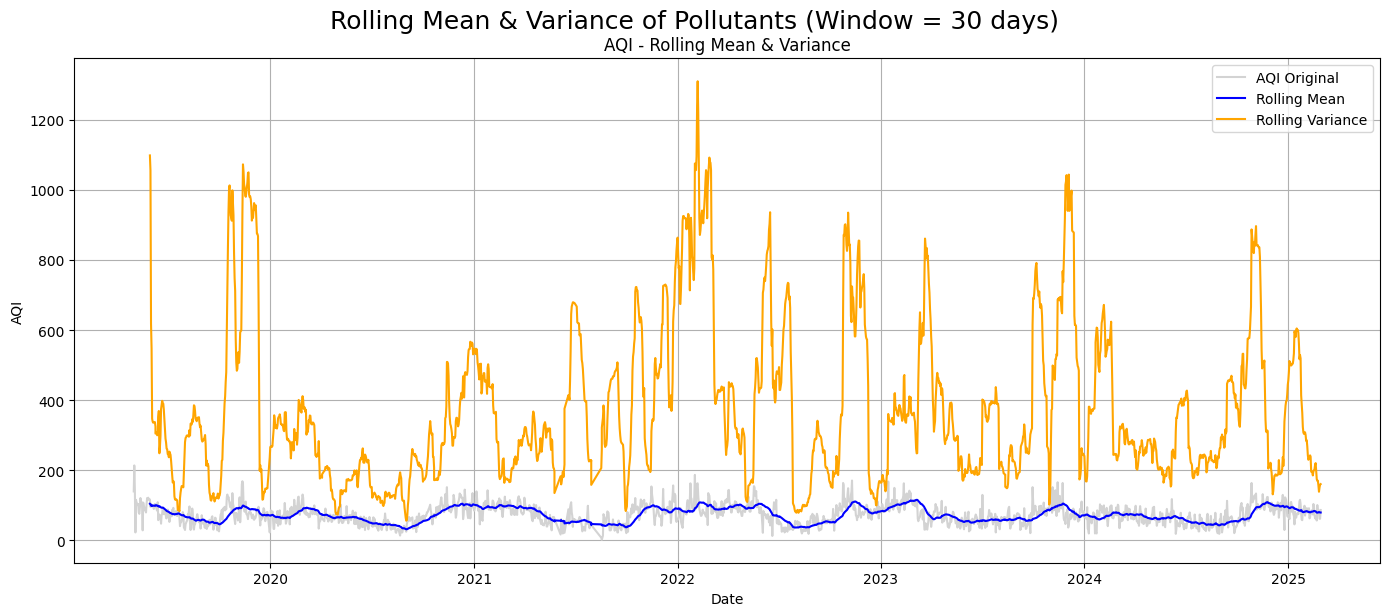

In [4]:
window = 30  # rolling window size in days

plt.figure(figsize=(14, 6))
plt.plot(df['AQI'], label=f'{'AQI'} Original', color='lightgray')
plt.plot(df['AQI'].rolling(window).mean(), label='Rolling Mean', color='blue')
plt.plot(df['AQI'].rolling(window).var(), label='Rolling Variance', color='orange')
plt.title(f'{'AQI'} - Rolling Mean & Variance')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.suptitle('Rolling Mean & Variance of Pollutants (Window = 30 days)', fontsize=18, y=1.02)
plt.show()


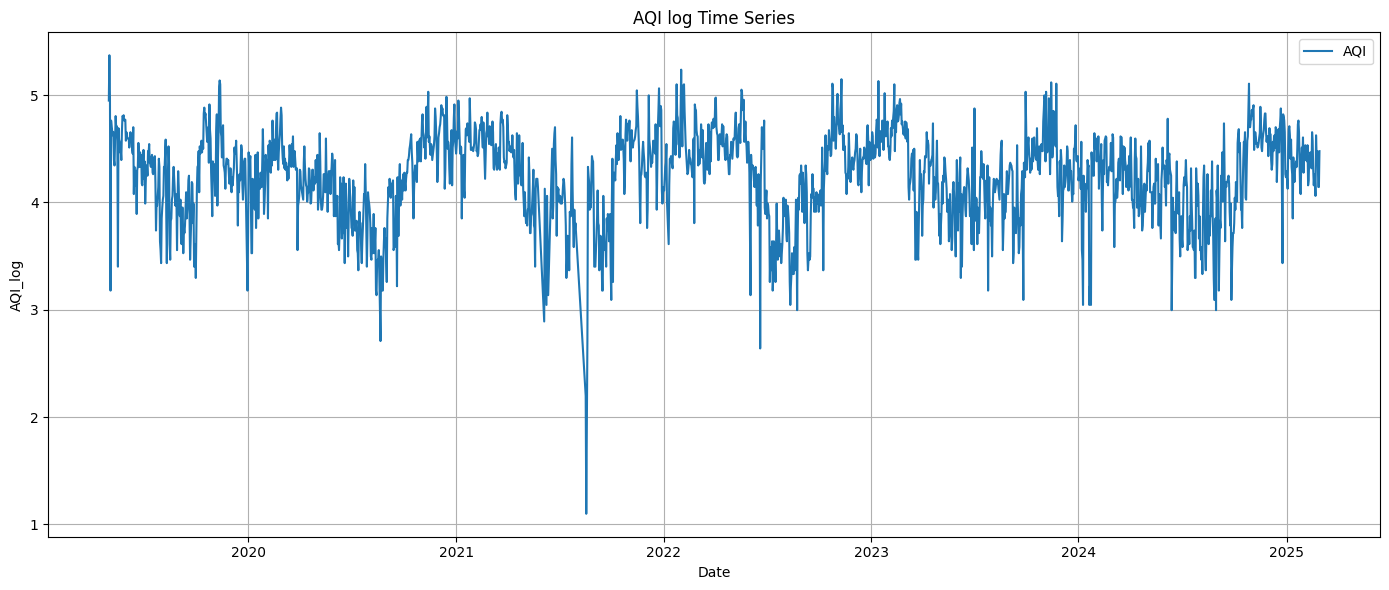

In [23]:
df['AQI_log'] = np.log(df['AQI'] + 1)  # Add 1 to avoid log(0)

# Plot AQI over time
plt.figure(figsize=(14, 6))
plt.plot(df['AQI_log'], label='AQI')
plt.title('AQI log Time Series')
plt.xlabel('Date')
plt.ylabel('AQI_log')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

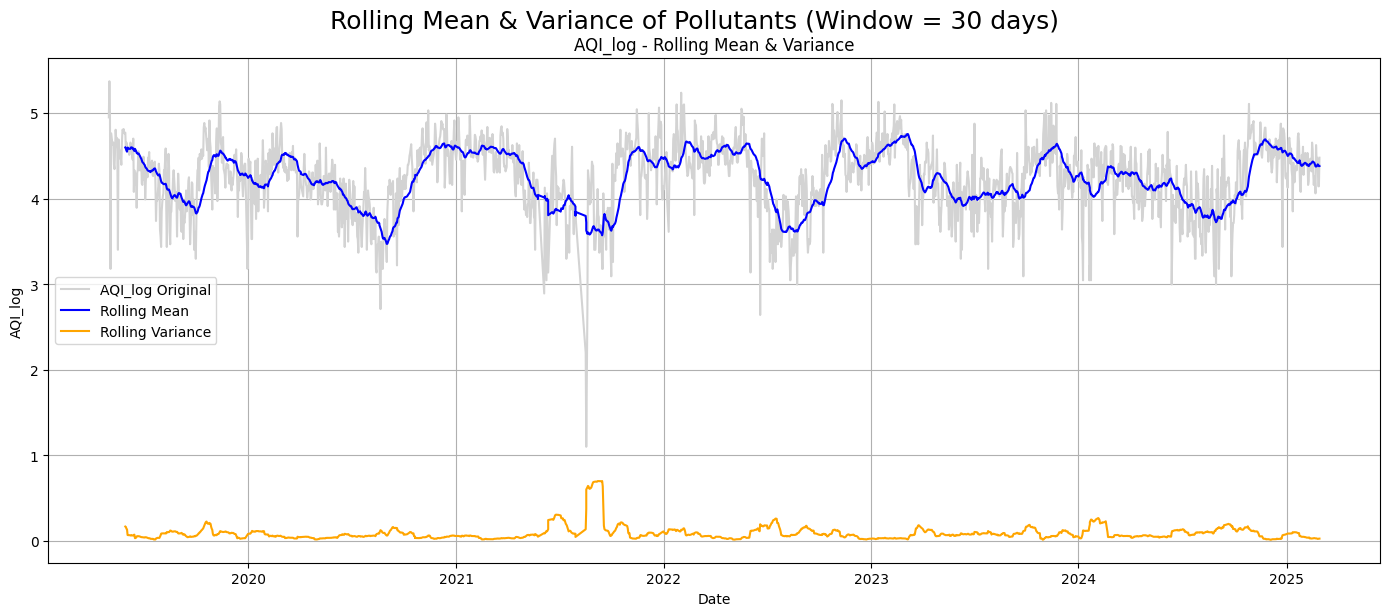

In [24]:
window = 30  # rolling window size in days

plt.figure(figsize=(14, 6))
plt.plot(df['AQI_log'], label=f'{'AQI_log'} Original', color='lightgray')
plt.plot(df['AQI_log'].rolling(window).mean(), label='Rolling Mean', color='blue')
plt.plot(df['AQI_log'].rolling(window).var(), label='Rolling Variance', color='orange')
plt.title(f'{'AQI_log'} - Rolling Mean & Variance')
plt.xlabel('Date')
plt.ylabel('AQI_log')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.suptitle('Rolling Mean & Variance of Pollutants (Window = 30 days)', fontsize=18, y=1.02)
plt.show()


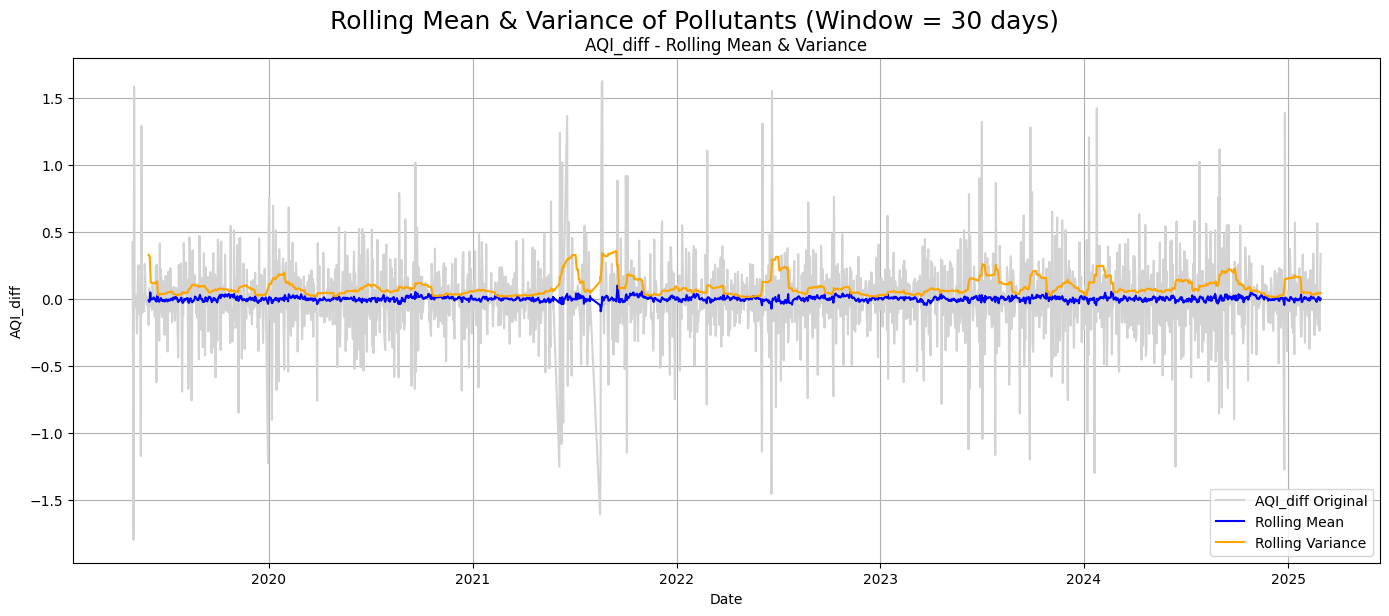

In [7]:
df['AQI_diff'] = df['AQI_log'].diff()
window = 30  # rolling window size in days

plt.figure(figsize=(14, 6))
plt.plot(df['AQI_diff'], label=f'{'AQI_diff'} Original', color='lightgray')
plt.plot(df['AQI_diff'].rolling(window).mean(), label='Rolling Mean', color='blue')
plt.plot(df['AQI_diff'].rolling(window).var(), label='Rolling Variance', color='orange')
plt.title(f'{'AQI_diff'} - Rolling Mean & Variance')
plt.xlabel('Date')
plt.ylabel('AQI_diff')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.suptitle('Rolling Mean & Variance of Pollutants (Window = 30 days)', fontsize=18, y=1.02)
plt.show()


<Figure size 1200x600 with 0 Axes>

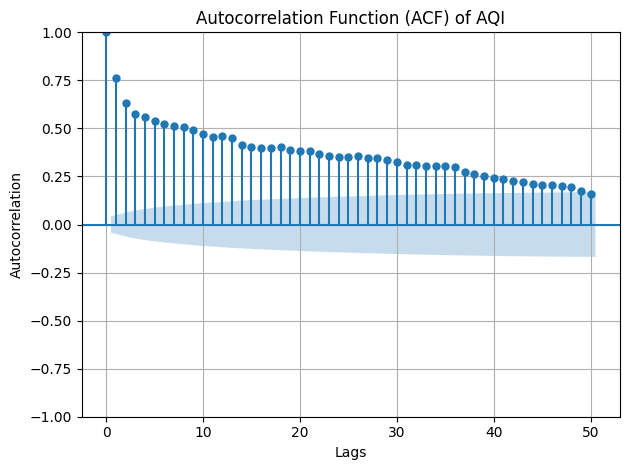

In [28]:
from statsmodels.graphics.tsaplots import plot_acf

# Drop NaN introduced by differencing
aqi_diff = df['AQI'].dropna()

# ACF Plot
plt.figure(figsize=(12, 6))
plot_acf(aqi_diff, lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF) of AQI')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

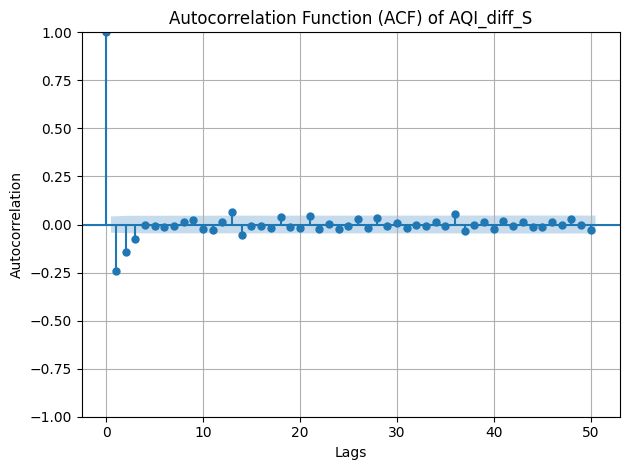

In [29]:
from statsmodels.graphics.tsaplots import plot_acf
df['AQI_diff_S'] = df['AQI'].diff()
# Drop NaN introduced by differencing
aqi_diff = df['AQI_diff_S'].dropna()

# ACF Plot
plt.figure(figsize=(12, 6))
plot_acf(aqi_diff, lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF) of AQI_diff_S')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

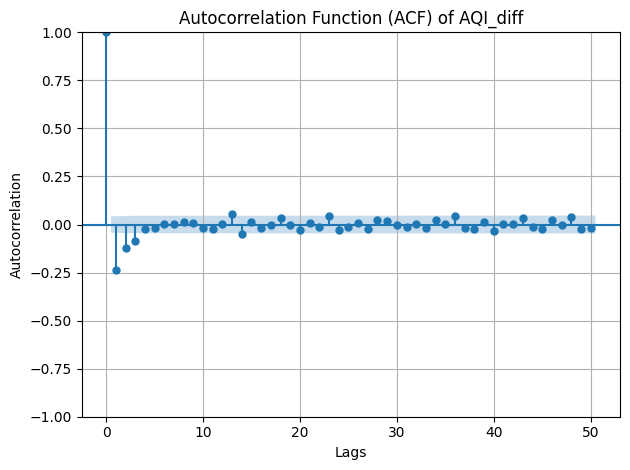

In [11]:
from statsmodels.graphics.tsaplots import plot_acf

# Drop NaN introduced by differencing
aqi_diff = df['AQI_diff'].dropna()

# ACF Plot
plt.figure(figsize=(12, 6))
plot_acf(aqi_diff, lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF) of AQI_diff')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.tight_layout()
plt.show()